In [105]:
import sys
sys.path.insert(0, '../')

import csaps
import typing
import numpy as np
import numpy
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

import pandas as pd

from src.vg2signal import read_raw_vg_as_df, make_shoulder_getter, make_detilter, make_smoother

In [106]:
def check_signal_validity(vg_filename: str,
             do_log: bool,
             smoothing_bw: float,
             vcenter: float,
             vwidth: float,
             stiffness: float):

    vg_df = read_raw_vg_as_df(vg_filename)

    if (vg_df['I'].to_numpy() < 0).any():
        temp = [None] * 11
        return None

    if do_log:
        cur_var_name = "logI"
        #vg_df[cur_var_name] = np.emath.logn(logbase, vg_df["I"])
        vg_df[cur_var_name] = np.log2(vg_df["I"])
    else:
        cur_var_name = "I"

    smoother = make_smoother(smoothing_bw)

    vg_df["smoothed"] = smoother(vg_df["V"], vg_df[cur_var_name].to_numpy())

    shoulder_getter = make_shoulder_getter(1, 1.1)
    (peak_signal, peak_v_shoulder) = shoulder_getter(vg_df["V"],
                                                     vg_df["smoothed"])

    vcenter = peak_v_shoulder
    vstart = vcenter - 0.5*vwidth
    vend = vcenter + 0.5*vwidth

    detilter = make_detilter(vstart, vend, stiffness)
    vg_df["detilted"] = detilter(vg_df["V"].to_numpy(),
                                 vg_df["smoothed"].to_numpy())
    
    max_signal = vg_df['detilted'].max()  
    min_signal = vg_df['detilted'].min()

    # Invalid data sample when the signal has negative peak higher than positive and has threshold above 0.009
    return (True if (abs(min_signal) > abs(max_signal)) and (abs(min_signal)>0.009) else False), vg_df


def make_detilter(vstart: float,
                  vend: float,
                  stiffness: float) -> typing.Callable:
    assert stiffness >= 0.0, \
        "invalid stiffness parameter (should be " + \
        f"greater than zero): {stiffness}"

    def detilter_func(v: numpy.array, lis: numpy.array):
        v_out  = numpy.logical_or(v < vstart, v > vend)
        lis_bg = csaps.csaps(v[v_out], lis[v_out], v,
                             smooth=(1.0 / (1.0 + stiffness)))
        return (lis - lis_bg), lis_bg

    return detilter_func

In [80]:
do_log        = True
recenter      = False
smoothing_bw  = 0.006
stiffness     = 1
vcenter       = 1.04
vwidth1       = 0.18

root_path     = '/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset'
filename_path = [*glob(f'{root_path}/ML1_ML2/2024_02_19_ML1/*.txt'), *glob(f'{root_path}/ML1_ML2/2024_02_22_ML2/*.txt'), *glob(f'{root_path}/ML4/*.txt')]

list_of_invalid_data = []

for filename in filename_path:
    is_invalid, _       = check_signal_validity(filename,
                            do_log,
                            smoothing_bw,
                            vcenter,
                            vwidth1,
                            stiffness)
        
    if is_invalid==None: continue
    if is_invalid: list_of_invalid_data.append(filename)

ValueError: Length of values (2) does not match length of index (175)

In [81]:
pd.Series(list_of_invalid_data).map(lambda x: x.split('/')[-1].replace('.txt', '')).to_list()

[]

In [107]:
from src.generate_dataset import v2signal_extra_features
from scipy.signal import savgol_filter, medfilt
from scipy.interpolate import UnivariateSpline

/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1/2024_02_19_cbz08_37.txt
Inside Fun 0.0002446317527846631
-1.4089133345274985 34.4207916859166


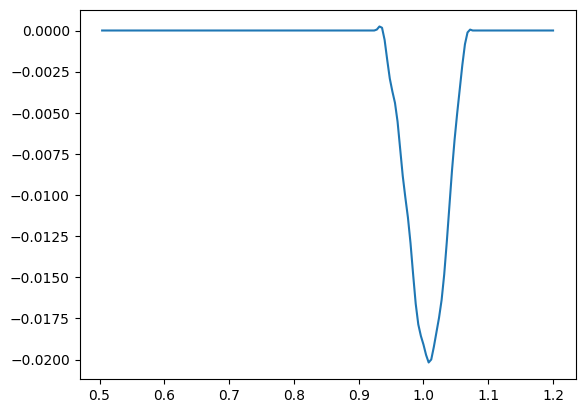

In [126]:
from glob import glob
import os

do_log        = True
recenter      = False
smoothing_bw  = 0.006
stiffness     = 0
vcenter       = 1.04
vwidth1       = 0.15

file     = '2024_02_19_cbz08_37'#'2024_02_22_cbz08_16.txt'
root_path     = os.path.realpath('../dataset')
filename_path = [*glob(f'{root_path}/ML1_ML2/2024_02_19_ML1/*.txt'), *glob(f'{root_path}/ML1_ML2/2024_02_22_ML2/*.txt'), *glob(f'{root_path}/ML4/*.txt')]


filename = [pathname for pathname in filename_path if (file in pathname)][0]

print(filename)
(peak_signal, peak_curvature, peak_v, vg_df, vcenter, ph, signal_mean, signal_std,\
                dS_dV_max_peak, dS_dV_min_peak, dS_dV_peak_diff, dS_dV_max_V, \
                dS_dV_min_V, dS_dV_area) = v2signal_extra_features(filename,
                                                                    do_log,
                                                                    smoothing_bw,
                                                                    vcenter,
                                                                    vwidth1,
                                                                    stiffness)

# if abs(vg_df['detilted'].min()) > abs(vg_df['detilted'].max()):
#     vg_df['detilted'] = -vg_df['detilted'] # Flip the signal

print(peak_signal, peak_curvature)
plt.plot(vg_df['V'], vg_df['detilted'])

In [127]:
# stiffness       = 0
shoulder_getter = make_shoulder_getter(1, 1.1)
(peak_signal, peak_v_shoulder) = shoulder_getter(vg_df["V"],
                                                     vg_df["smoothed"])

vwidth  = vwidth1

vcenter = peak_v_shoulder
vstart  = vcenter - 0.5*vwidth
vend    = vcenter + 0.5*vwidth

v  = vg_df["V"].to_numpy()
lis= vg_df["smoothed"].to_numpy()

v_out  = numpy.logical_or(v < vstart, v > vend)
lis_bg = csaps.csaps(v[v_out], lis[v_out], v,
                     smooth=(1.0 / (1.0 + stiffness)))

1.0
       V      I      logI  smoothed  detilted
124  1.0  4.487  2.165751  2.164541 -0.019092


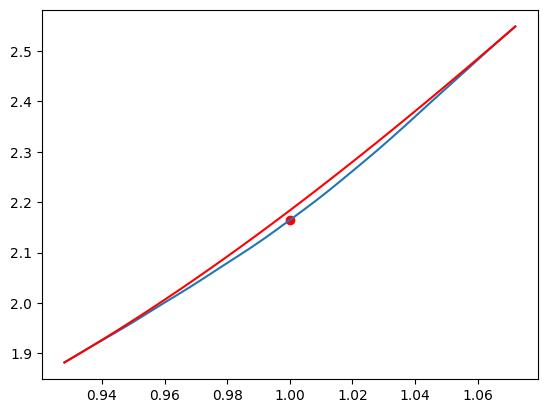

In [128]:
clip_mask = (vg_df['V'] > vstart) & (vg_df['V'] < vend)

signal_peak = vg_df[vg_df['V']==vcenter]

print(vcenter)
print(signal_peak)


plt.plot(vg_df['V'][clip_mask], vg_df['smoothed'][clip_mask])
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='red')
plt.plot(vg_df['V'][clip_mask], lis_bg[clip_mask], c='red', )

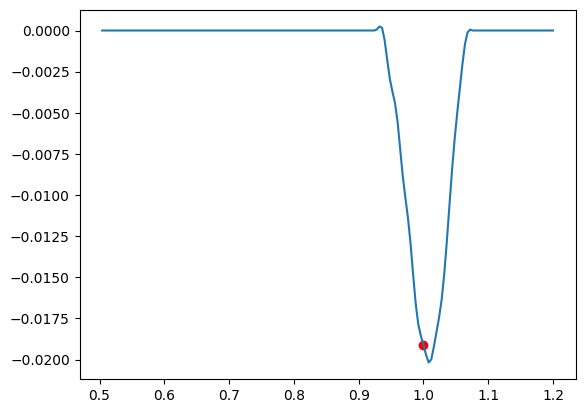

In [129]:
signal_peak = vg_df[vg_df['V']==vcenter]
plt.plot(vg_df['V'], vg_df['detilted'])
plt.scatter(signal_peak['V'], signal_peak['detilted'], c='red')

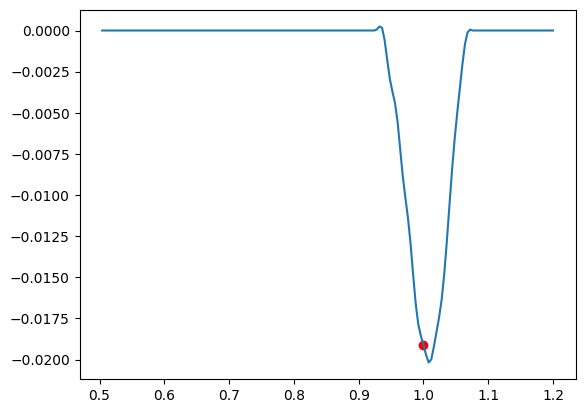

In [130]:
signal_peak = vg_df[vg_df['V']==vcenter]
plt.plot(vg_df['V'], vg_df['detilted'])
plt.scatter(signal_peak['V'], signal_peak['detilted'], c='red')

0.925 1.075


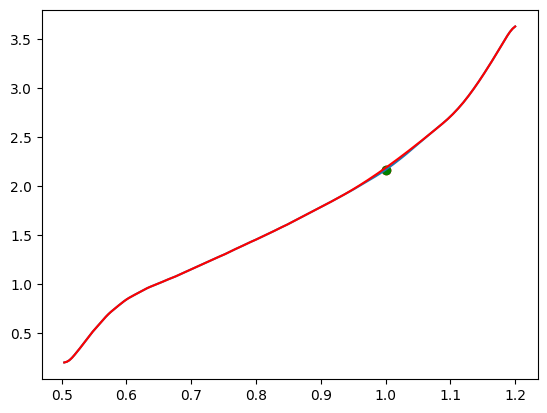

In [131]:
clip_mask = (vg_df['V'] > vstart) & (vg_df['V'] < vend)

signal_peak = vg_df[vg_df['V']==vcenter]

plt.plot(vg_df['V'], vg_df['smoothed'])
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='red')
plt.plot(vg_df['V'], lis_bg, c='red', )

print(vstart, vend)
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='green')

signal_peak = vg_df[vg_df['V']==vend]
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='green')

In [132]:
vg_df['V'].max()

1.2

In [ ]:
plt.plot(vg_df['V'], vg_df['detilted'])

In [ ]:
plt.plot(vg_df['V'], vg_df['detilted'].clip(lower=0.0))